<a href="https://colab.research.google.com/github/maximoalva/TP2-AprendizajeAutomaticoII/blob/main/Audio-MNIST/audio_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico N°2 - Redes neuronales recurrentes y Q-learning

---
Aprendizaje Automático II

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura

Universidad Nacional de Rosario

2025

Estudiantes:

*   Máximo Alva
*   María Sol Aranda

# Problema 1 - Audio MNIST
---
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

*   Modelo convolucional sobre los espectrogramas de los clips.
*   Modelo recurrente sobre los espectrogramas de los clips.

## Preparación del entorno

Importar librerías.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display
from time import time
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import Input, Normalization, Resizing, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Configurar para que TensorFlow asigne memoria dinámicamente
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # Especificar la GPU por defecto
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Manejar error
    print(e)

Función para graficar loss y acurracy de los modelos.

In [ ]:
def plot_history(history):
  """
  Grafica la pérdida y precisión de entrenamiento y validación
  a lo largo de las épocas.

  Parámetros:
  - history [keras.callbacks.History]: objeto retornado por model.fit()
  """
  plt.figure(figsize=(14, 4), facecolor="#282A2C")

  # Visualización pérdida del modelo
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Entrenamiento')
  plt.plot(history.history['val_loss'], label='Validación')
  plt.ylim([0, max(plt.ylim())])
  plt.tick_params(axis='x', colors='white')
  plt.tick_params(axis='y', colors='white')
  plt.title('Pérdida del modelo', color="white")
  plt.xlabel('Época', color="white")
  plt.ylabel('Loss', color="white")
  plt.legend()

  # Visualización precisión del modelo
  plt.subplot(1, 2, 2)
  plt.plot([a * 100 for a in history.history['accuracy']], label='Entrenamiento')
  plt.plot([a * 100 for a in history.history['val_accuracy']], label='Validación')
  plt.ylim([0, 100])
  plt.tick_params(axis='x', colors='white')
  plt.tick_params(axis='y', colors='white')
  plt.title('Precisión del modelo', color="white")
  plt.xlabel('Época', color="white")
  plt.ylabel('Accuracy (%)', color="white")
  plt.legend()

  plt.tight_layout()
  plt.show()

Función para graficar la matriz de confusión de los modelos.

In [ ]:
def plot_confusion_matrix(y_pred, y_true, label_names):
  """
  Grafica una matriz de confusión.

  Parámetros:
  - y_true [EagerTensor]: etiquetas reales
  - y_pred [EagerTensor]: etiquetas predichas
  - label_names [list]: nombres de las clases
  """
  plt.figure(figsize=(8, 6), facecolor="#282A2C")
  sns.heatmap(tf.math.confusion_matrix(y_true, y_pred), xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g', cmap="coolwarm")

  plt.tick_params(axis='x', colors='white')
  plt.tick_params(axis='y', colors='white')
  plt.title("Matriz de confusión", color="white")
  plt.xlabel('Predicción', color="white")
  plt.ylabel('Real', color="white")
  # Ajustar barra de color
  cbar = plt.gca().collections[0].colorbar
  cbar.ax.yaxis.set_tick_params(color='white')
  plt.setp(cbar.ax.get_yticklabels(), color='white')

  plt.show()

## Cargar dataset

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos,
50 clips por dígito por locutor.

In [ ]:
# Cargar el dataset 'spoken_digit'
ds, ds_info = tfds.load('spoken_digit', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.GWDIOS_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


In [ ]:
# Nombres de las clases
label_names = ds_info.features['label'].names
print("Label names:", label_names)
# Número de clases
num_labels = len(label_names)
print("Num labels:", num_labels)

Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Num labels: 10


### División en conjuntos de entrenamiento y validación

In [ ]:
full_ds = ds['train']
# Calcular tamaños
full_size = ds_info.splits['train'].num_examples
train_size = int(0.8 * full_size)
# Dividir en train y validation (80/20)
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size)

print(f"Total:\t\t{full_size}\nTrain:\t\t{train_size}\nValidation:\t{full_size - train_size}")

Total:		2500
Train:		2000
Validation:	500


## Análisis exploratorio y preprocesamiento

In [ ]:
# Obtener longitudes de los audios
lengths = list()
for audio, _ in train_ds:
  lengths.append(len(audio))
# Mostrar estadísticas básicas
lengths = np.array(lengths)
print(f"Cantidad mínima de muestras:\t{lengths.min()}")
print(f"Cantidad máxima de muestras:\t{lengths.max()}")
print(f"Cantidad promedio de muestras:\t{int(lengths.mean())}")
print(f"Cantidad mediana de muestras:\t{int(np.median(lengths))}")

Cantidad mínima de muestras:	1288
Cantidad máxima de muestras:	8281
Cantidad promedio de muestras:	3281
Cantidad mediana de muestras:	3200


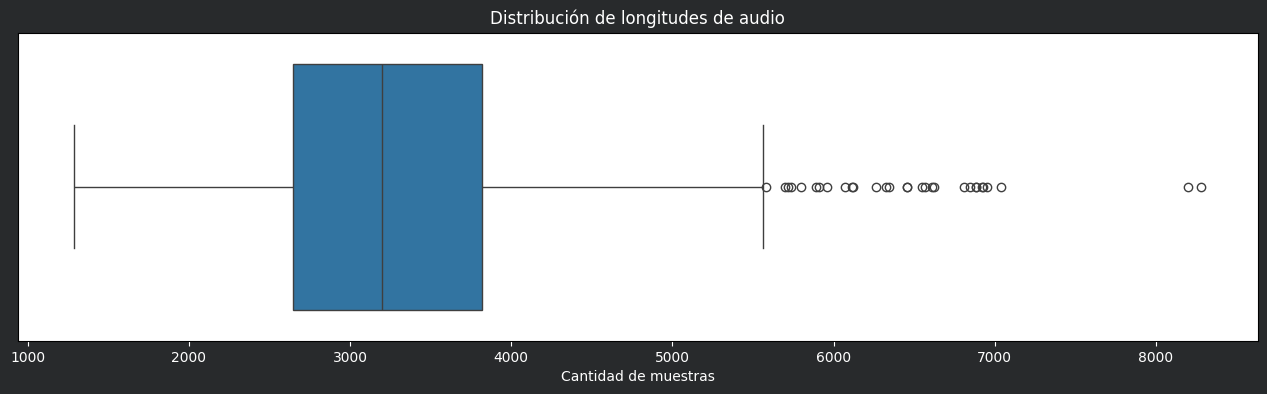

In [ ]:
# Graficar boxplot
plt.figure(figsize=(16, 4), facecolor="#282A2C")
sns.boxplot(x=lengths)
plt.title("Distribución de longitudes de audio", color="white")
plt.xlabel("Cantidad de muestras", color="white")
plt.tick_params(axis='x', colors='white')
plt.yticks([])
plt.show()

In [ ]:
for audio, label in train_ds.take(6):
  print(f"Label: {label.numpy()}")
  print(f"Audio shape: {audio.shape}")
  print(f"Amplitud:[{tf.reduce_min(audio).numpy():.2f}: {tf.reduce_max(audio).numpy():.2f}]")
  display.display(display.Audio(audio, rate=8000))

Label: 2
Audio shape: (1525,)
Amplitud:[-3072.00: 2560.00]


Label: 1
Audio shape: (2929,)
Amplitud:[-8448.00: 5376.00]


Label: 9
Audio shape: (6457,)
Amplitud:[-1119.00: 1468.00]


Label: 9
Audio shape: (3360,)
Amplitud:[-2111.00: 1264.00]


Label: 7
Audio shape: (2746,)
Amplitud:[-7936.00: 7680.00]


Label: 5
Audio shape: (3306,)
Amplitud:[-718.00: 1026.00]


### Preprocesamiento de audio

In [ ]:
def preprocess_audio(audio, label, len=7000):
  # Descartar ejes extra
  audio = tf.squeeze(audio)
  # Recortar si el audio es mayor a 7000 muestras
  audio = audio[:len]
  # Padding si el audio es menor a 7000 muestras
  paddings = [[0, tf.maximum(0, len - tf.shape(audio)[0])]]
  audio = tf.pad(audio, paddings, mode='CONSTANT')
  # Normalizar amplitud a [-1, 1]
  audio = tf.cast(audio, tf.float32)
  audio = audio / tf.reduce_max(tf.abs(audio))

  return audio, label

In [ ]:
train_ds = train_ds.map(preprocess_audio, tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_audio, tf.data.AUTOTUNE)

In [ ]:
for audio, label in train_ds.take(6):
  print(f"Label: {label.numpy()}")
  print(f"Audio shape: {audio.shape}")
  print(f"Amplitud:[{tf.reduce_min(audio).numpy():.2f}: {tf.reduce_max(audio).numpy():.2f}]")
  display.display(display.Audio(audio, rate=8000))

Label: 2
Audio shape: (7000,)
Amplitud:[-1.00: 0.83]


Label: 1
Audio shape: (7000,)
Amplitud:[-1.00: 0.64]


Label: 9
Audio shape: (7000,)
Amplitud:[-0.76: 1.00]


Label: 9
Audio shape: (7000,)
Amplitud:[-1.00: 0.60]


Label: 7
Audio shape: (7000,)
Amplitud:[-1.00: 0.97]


Label: 5
Audio shape: (7000,)
Amplitud:[-0.70: 1.00]


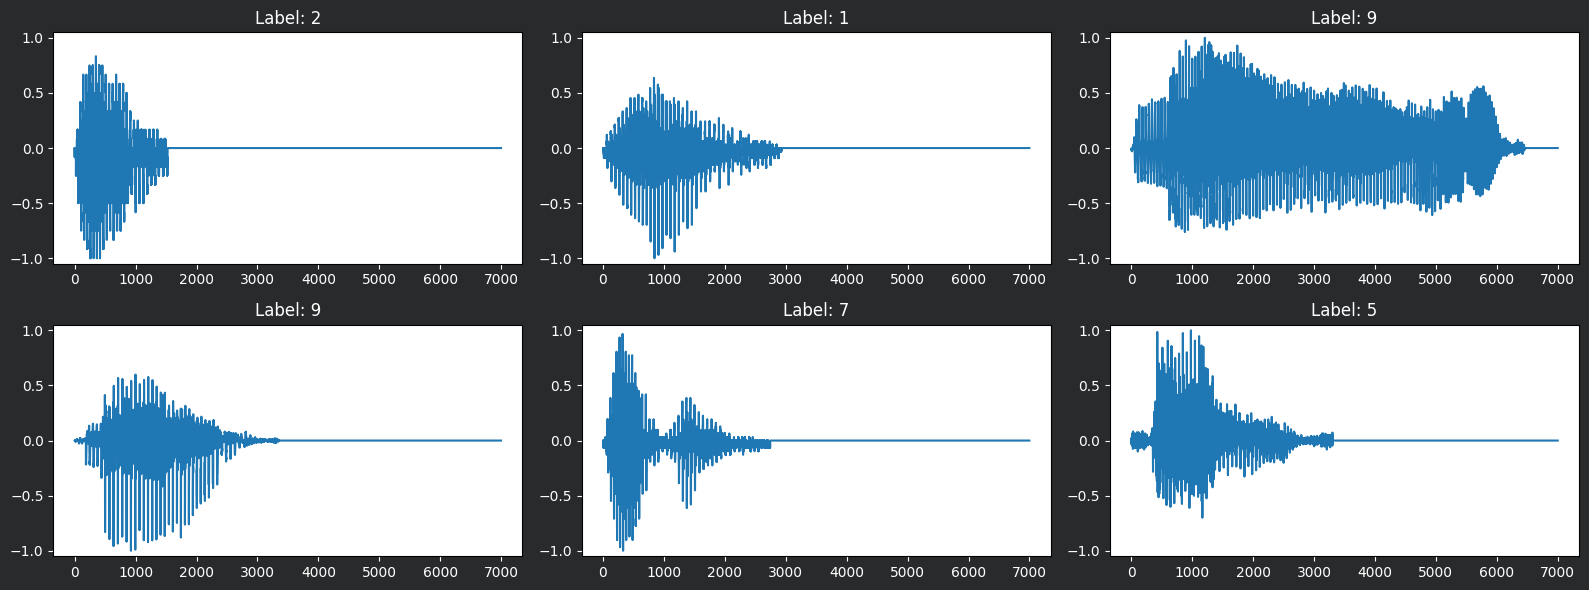

In [ ]:
plt.figure(figsize=(16, 6), facecolor="#282A2C")
rows, cols = 2, 3
for i, (audio, label) in enumerate(train_ds.take(6)):
  plt.subplot(rows, cols, i+1)
  plt.plot(audio.numpy())
  plt.title(f"Label: {label.numpy()}", color='white')
  plt.ylim([-1.05, 1.05])
  plt.tick_params(axis='x', colors='white')
  plt.tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()

### Convertir formas de onda a espectogramas

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a 'channels' dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape ('batch_size', 'height', 'width', 'channels').
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [ ]:
train_ds = train_ds.map(lambda x, y: (get_spectrogram(x), y), tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (get_spectrogram(x), y), tf.data.AUTOTUNE)

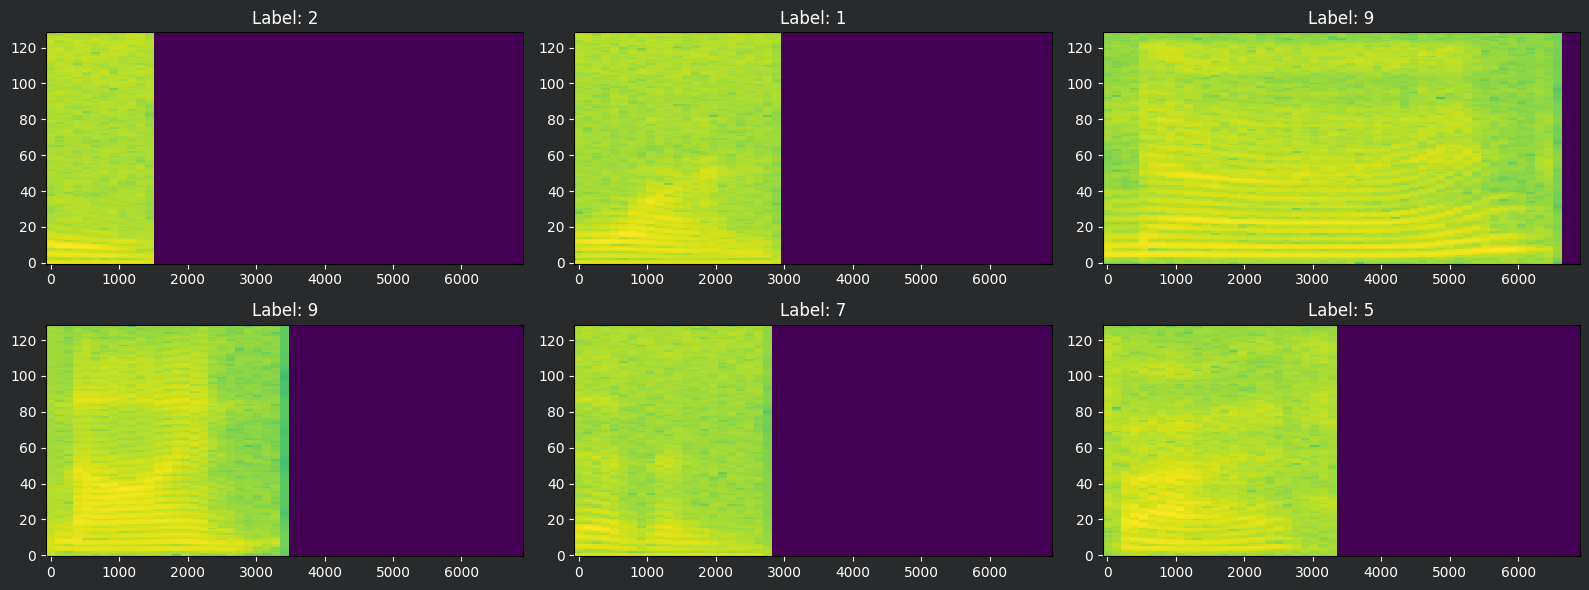

In [ ]:
plt.figure(figsize=(16, 6), facecolor="#282A2C")
rows, cols = 2, 3
for i, (spectogram, label) in enumerate(train_ds.take(6)):
  ax = plt.subplot(rows, cols, i+1)
  plot_spectrogram(spectogram.numpy(), ax)
  plt.title(f"Label: {label.numpy()}", color='white')
  plt.tick_params(axis='x', colors='white')
  plt.tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()

### Batching

In [ ]:
BATCH_SIZE = 64
# Aplicar batching para el entrenamiento
train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(2000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for spectogram_batch, label_batch in train_ds.take(1):
  print(f"Spectogram batch shape: {spectogram_batch.shape}\nLabel batch shape: {label_batch.shape}")

Spectogram batch shape: (64, 53, 129, 1)
Label batch shape: (64,)


## Modelo convolucional

### Arquitectura de la red

In [ ]:
def build_conv_model(input_shape, num_labels, train_ds):
  # Instantiate the 'tf.keras.layers.Normalization' layer.
  norm_layer = Normalization()
  # Fit the state of the layer to the spectrograms with 'Normalization.adapt'
  norm_layer.adapt(data=train_ds.map(lambda spec, label: spec))
  # Input
  i = Input(shape=input_shape)
  # Downsample the input.
  x = Resizing(32, 32)(i)
  # Normalize.
  x = norm_layer(x)
  # Bloques convolucionales
  x = Conv2D(32, 3, activation='relu')(x)
  x = Conv2D(64, 3, activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Dropout(0.25)(x)
  # Clasificación
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(num_labels)(x)

  return Model(inputs=i, outputs=x)

In [ ]:
# Obtener input_shape desde un batch de espectrogramas
for spectrogram_batch, label_batch in train_ds.take(1):
  input_shape = spectrogram_batch.shape[1:] # (alto, ancho, canales)

In [ ]:
conv_model = build_conv_model(input_shape, num_labels, train_ds)
conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 53, 129, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

### Compilación

In [ ]:
conv_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
)

### Entrenamiento

In [ ]:
# Iniciar reloj
start = time()
# Entrenamiento
conv_history = conv_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)
)
# Mostrar tiempo de ejecución
end = time()
total_time = end - start
print(f"Tiempo de ejecución: {int(total_time // 60)} min {int(total_time % 60)} s")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.3695 - loss: 1.8223 - val_accuracy: 0.7380 - val_loss: 0.7720
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7474 - loss: 0.7847 - val_accuracy: 0.8740 - val_loss: 0.4698
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8353 - loss: 0.5039 - val_accuracy: 0.8900 - val_loss: 0.3320
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8800 - loss: 0.3788 - val_accuracy: 0.9100 - val_loss: 0.3029
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9233 - loss: 0.2687 - val_accuracy: 0.9300 - val_loss: 0.2126
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9377 - loss: 0.1999 - val_accuracy: 0.9500 - val_loss: 0.1728
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9407 - loss: 0.1928 - val_accuracy: 0.9400 - val_loss: 0.1725
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9603 - loss: 0.1339 - val_accuracy: 0.

### Evaluación

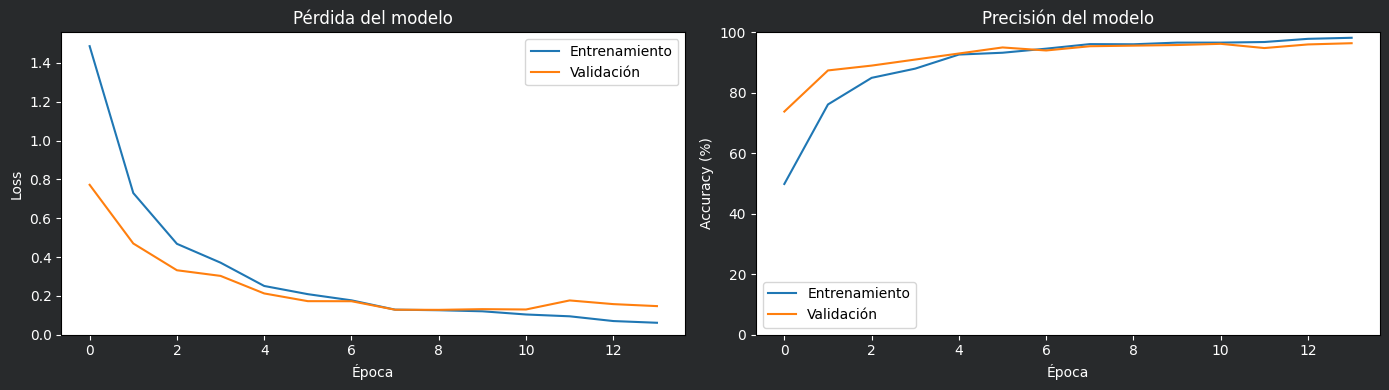

In [ ]:
plot_history(conv_history)

In [ ]:
conv_y_pred = conv_model.predict(val_ds)
y_pred = tf.argmax(conv_y_pred, axis=1)
y_true = tf.concat(list(val_ds.map(lambda s, lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


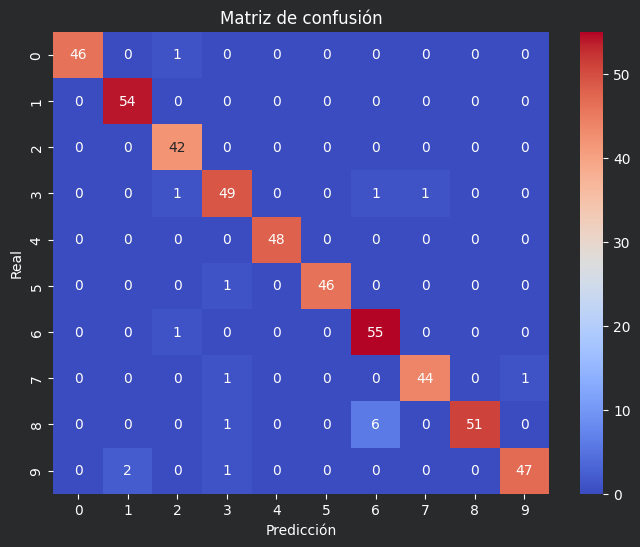

In [ ]:
plot_confusion_matrix(y_pred, y_true, label_names)

## Modelo recurrente

### Arquitectura de la red

In [ ]:
def build_rnn_model(input_shape, num_labels, train_ds):
  # Instantiate the 'tf.keras.layers.Normalization' layer.
  norm_layer = Normalization()
  # Fit the state of the layer to the spectrograms with 'Normalization.adapt'
  norm_layer.adapt(data=train_ds.map(lambda spec, label: spec))
  # Input
  i = Input(shape=input_shape)
  # Downsample the input.
  x = Resizing(32, 32)(i)
  # Normalize.
  x = norm_layer(x)

### Compilación

### Entrenamiento

In [ ]:
# Iniciar reloj
start = time()
# Entrenamiento

# Mostrar tiempo de ejecución
end = time()
total_time = end - start
print(f"Tiempo de ejecución: {int(total_time // 60)} min {int(total_time % 60)} s")

### Evaluación

In [ ]:
plot_history(rnn_history)

In [ ]:
rnn_y_pred = rnn_model.predict(val_ds)
y_pred = tf.argmax(rnn_y_pred, axis=1)
y_true = tf.concat(list(val_ds.map(lambda s, lab: lab)), axis=0)

In [ ]:
plot_confusion_matrix(y_pred, y_true, label_names)